## Import dependencies

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import missingno as msno

from utils import *

from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.metrics import roc_auc_score
from sklearn.feature_selection import SelectKBest
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import StandardScaler

# magic word for producing visualizations in notebook
%matplotlib inline

# and setting the size of all plots.
plt.rcParams['figure.figsize'] = [11, 7]

## Exploratory Data Analysis (EDA)

In [2]:
!ls

1.Exploratory Data Analysis.ipynb
2.Experiments - ML Challenge Solution - AUC  0.87833.ipynb
2.Experiments.ipynb
3.Experiments - XGBoostClassifier (GridSearch Optimization) - AUC 0.88335-Copy1.ipynb
3.Experiments - XGBoostClassifier (GridSearch Optimization) - AUC 0.88335.ipynb
4.Experiments - RUSBoostClassifier (Bayesian Optimization) - AUC 0.87795.ipynb
5.Experiments - BalancedRandomForest (Bayesian Optimization) - AUC 0.87623.ipynb
6.Experiments - Voting Classifier - AUC 0.88166.ipynb
7.Experiments - DeepLearning with fast.ai Tabular-Copy1.ipynb
7.Experiments - DeepLearning with fast.ai Tabular-Copy2.ipynb
7.Experiments - DeepLearning with fast.ai Tabular.ipynb
8.Experiments - XGBoostClassifier (Bayesian Optimization) - AUC 0.8814.ipynb
README.md
__pycache__
data
temp
utils.py


In [3]:
!ls data

census-income.data
census-income.data.html
census-income.names
census-income.test
census.tar.gz
sampleSubmission.csv
sample_submission.csv
solution.csv
test.csv
train.csv


In [4]:
!head -n 5 data/census-income.data

73, Not in universe, 0, 0, High school graduate, 0, Not in universe, Widowed, Not in universe or children, Not in universe, White, All other, Female, Not in universe, Not in universe, Not in labor force, 0, 0, 0, Nonfiler, Not in universe, Not in universe, Other Rel 18+ ever marr not in subfamily, Other relative of householder, 1700.09, ?, ?, ?, Not in universe under 1 year old, ?, 0, Not in universe, United-States, United-States, United-States, Native- Born in the United States, 0, Not in universe, 2, 0, 95, - 50000.
58, Self-employed-not incorporated, 4, 34, Some college but no degree, 0, Not in universe, Divorced, Construction, Precision production craft & repair, White, All other, Male, Not in universe, Not in universe, Children or Armed Forces, 0, 0, 0, Head of household, South, Arkansas, Householder, Householder, 1053.55, MSA to MSA, Same county, Same county, No, Yes, 1, Not in universe, United-States, United-States, United-States, Native- Born in the United States, 0, Not in uni

From the above listing we can conclude the following:

* There is no header present in the data file. We will have to compute our own based on the documentation
* There is a space after the comma `,` so our separator will be `, ` or `,\s` as RegEx. 
* The missing values are represented by a question mark `?`

### Read the dataset

In [5]:
# The C engine doesn't support RegEx so we set it to Python to avoid the warning
#census = pd.read_csv('data/census-income.data', header=None, sep=',\s', na_values=['?'], engine='python')
census = pd.read_csv('data/census-income.data', header=None, sep=',\s', na_values=['?', 'Do not know', 'Not identifiable'], engine='python')
census.head()

,0,1,2,3,4,5,6,7,8,9,...,32,33,34,35,36,37,38,39,40,41
0,73,Not in universe,0,0,High school graduate,0,Not in universe,Widowed,Not in universe or children,Not in universe,...,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,2,0,95,- 50000.
1,58,Self-employed-not incorporated,4,34,Some college but no degree,0,Not in universe,Divorced,Construction,Precision production craft & repair,...,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,2,52,94,- 50000.
2,18,Not in universe,0,0,10th grade,0,High school,Never married,Not in universe or children,Not in universe,...,Vietnam,Vietnam,Vietnam,Foreign born- Not a citizen of U S,0,Not in universe,2,0,95,- 50000.
3,9,Not in universe,0,0,Children,0,Not in universe,Never married,Not in universe or children,Not in universe,...,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,0,0,94,- 50000.
4,10,Not in universe,0,0,Children,0,Not in universe,Never married,Not in universe or children,Not in universe,...,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,0,0,94,- 50000.


Build a lists with columns names based on the provided documentation

In [6]:
census_columns = [
    'age',
    'class of worker',
    'detailed industry recode',
    'detailed occupation recode',
    'education',
    'wage per hour',
    'enroll in edu inst last wk',
    'marital status',
    'major industry code',
    'major occupation code',
    'race',
    'hispanic origin',
    'sex',
    'member of a labor union',
    'reason for unemployment',
    'full or part time employment stat',
    'capital gains',
    'capital losses',
    'dividends from stocks',
    'tax filer stat',
    'region of previous residence',
    'state of previous residence',
    'detailed household and family stat',
    'detailed household summary in household',
    'instance weight',
    'migration code-change in msa',
    'migration code-change in reg',
    'migration code-move within reg',
    'live in this house 1 year ago',
    'migration prev res in sunbelt',
    'num persons worked for employer',
    'family members under 18',
    'country of birth father',
    'country of birth mother',
    'country of birth self',
    'citizenship',
    'own business or self employed',
    'fill inc questionnaire for veteran\'s admin',
    'veterans benefits',
    'weeks worked in year',
    'year',
    'income class'
]

Set the column names to the dataset

In [7]:
census.columns = census_columns

In [8]:
census.head()

,age,class of worker,detailed industry recode,detailed occupation recode,education,wage per hour,enroll in edu inst last wk,marital status,major industry code,major occupation code,...,country of birth father,country of birth mother,country of birth self,citizenship,own business or self employed,fill inc questionnaire for veteran's admin,veterans benefits,weeks worked in year,year,income class
0,73,Not in universe,0,0,High school graduate,0,Not in universe,Widowed,Not in universe or children,Not in universe,...,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,2,0,95,- 50000.
1,58,Self-employed-not incorporated,4,34,Some college but no degree,0,Not in universe,Divorced,Construction,Precision production craft & repair,...,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,2,52,94,- 50000.
2,18,Not in universe,0,0,10th grade,0,High school,Never married,Not in universe or children,Not in universe,...,Vietnam,Vietnam,Vietnam,Foreign born- Not a citizen of U S,0,Not in universe,2,0,95,- 50000.
3,9,Not in universe,0,0,Children,0,Not in universe,Never married,Not in universe or children,Not in universe,...,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,0,0,94,- 50000.
4,10,Not in universe,0,0,Children,0,Not in universe,Never married,Not in universe or children,Not in universe,...,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,0,0,94,- 50000.


In [9]:
census.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 199523 entries, 0 to 199522
Data columns (total 42 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   age                                         199523 non-null  int64  
 1   class of worker                             199523 non-null  object 
 2   detailed industry recode                    199523 non-null  int64  
 3   detailed occupation recode                  199523 non-null  int64  
 4   education                                   199523 non-null  object 
 5   wage per hour                               199523 non-null  int64  
 6   enroll in edu inst last wk                  199523 non-null  object 
 7   marital status                              199523 non-null  object 
 8   major industry code                         199523 non-null  object 
 9   major occupation code                       199523 non-null  object 
 

Try to reduce the size of the data-frame and set correct data types

In [10]:
census, _ = reduce_mem_usage(census)

Memory usage of dataframe:  63.93418884277344  MB



___MEMORY USAGE AFTER COMPLETION:___
Memory usage is: 48.7117919921875 MB
This is 76.19% of the initial size


In [11]:
census.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 199523 entries, 0 to 199522
Data columns (total 42 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   age                                         199523 non-null  uint8  
 1   class of worker                             199523 non-null  object 
 2   detailed industry recode                    199523 non-null  uint8  
 3   detailed occupation recode                  199523 non-null  uint8  
 4   education                                   199523 non-null  object 
 5   wage per hour                               199523 non-null  uint16 
 6   enroll in edu inst last wk                  199523 non-null  object 
 7   marital status                              199523 non-null  object 
 8   major industry code                         199523 non-null  object 
 9   major occupation code                       199523 non-null  object 
 

The documentation says to ignore the `instance weight` column

In [12]:
# Make a copy first
census_clean = census.copy()
census_clean = census_clean.drop('instance weight', axis=1)
census_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 199523 entries, 0 to 199522
Data columns (total 41 columns):
 #   Column                                      Non-Null Count   Dtype 
---  ------                                      --------------   ----- 
 0   age                                         199523 non-null  uint8 
 1   class of worker                             199523 non-null  object
 2   detailed industry recode                    199523 non-null  uint8 
 3   detailed occupation recode                  199523 non-null  uint8 
 4   education                                   199523 non-null  object
 5   wage per hour                               199523 non-null  uint16
 6   enroll in edu inst last wk                  199523 non-null  object
 7   marital status                              199523 non-null  object
 8   major industry code                         199523 non-null  object
 9   major occupation code                       199523 non-null  object
 10  race    

## Missing Values

Look at the columns and their missing values

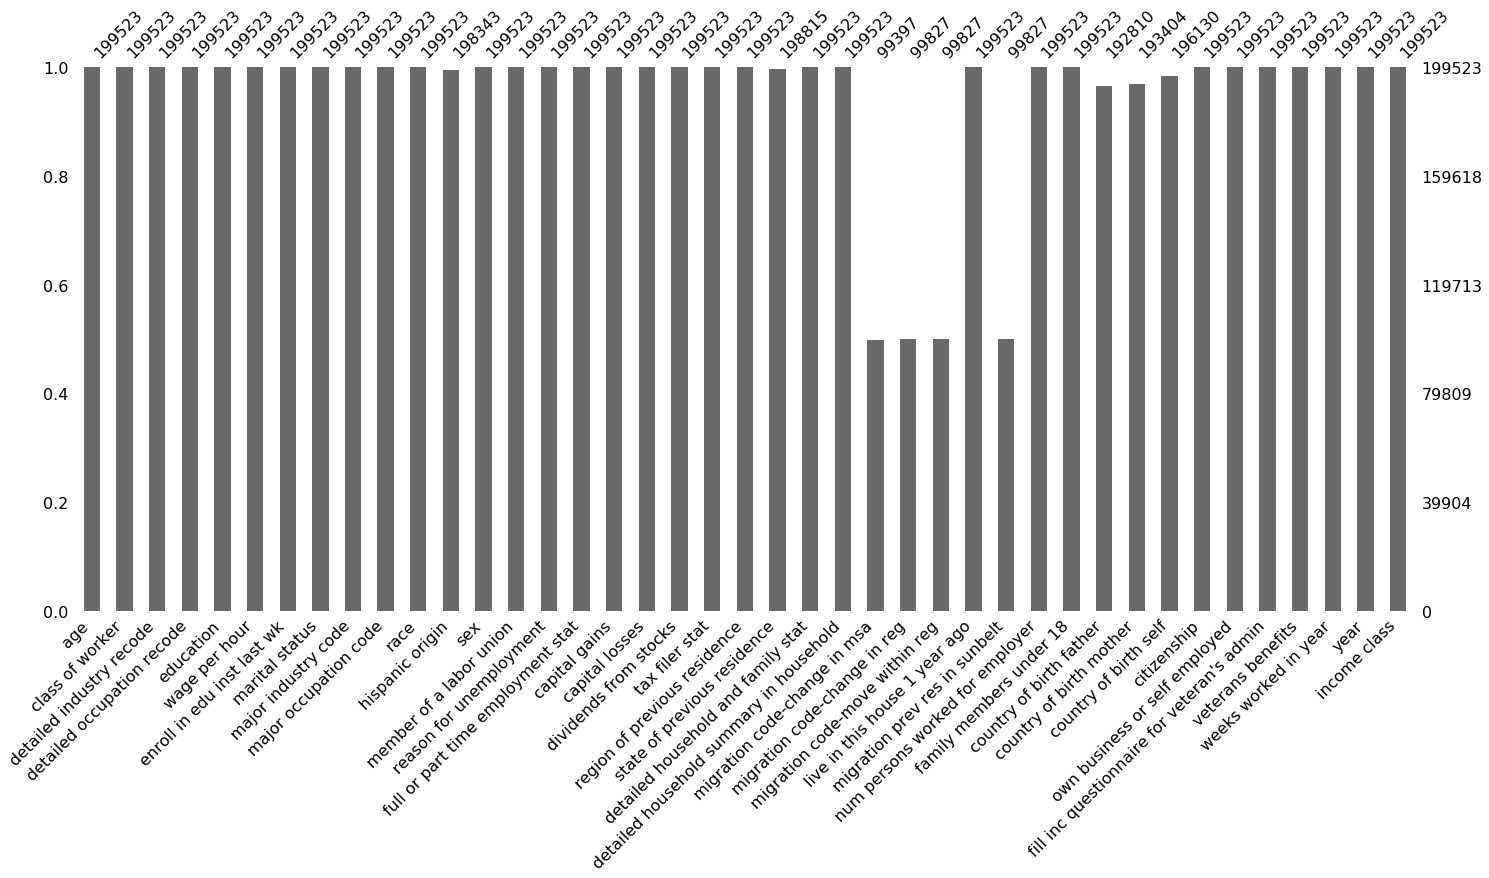

In [13]:
_ = msno.bar(census_clean)

In [14]:
column_nans = nans_count(census_clean)
column_nans.sort_values('nan_count', ascending=False)

,nan_count
migration code-change in msa,50.182686
migration code-change in reg,49.967172
migration code-move within reg,49.967172
migration prev res in sunbelt,49.967172
country of birth father,3.364524
country of birth mother,3.066814
country of birth self,1.700556
hispanic origin,0.591411
state of previous residence,0.354846


In [15]:
categorical = census_clean.select_dtypes(include='object')
unique_values(categorical)

class of worker: ['Not in universe', 'Self-employed-not incorporated', 'Private', 'Local government', 'Federal government', 'Self-employed-incorporated', 'State government', 'Never worked', 'Without pay']
education: ['High school graduate', 'Some college but no degree', '10th grade', 'Children', 'Bachelors degree(BA AB BS)', 'Masters degree(MA MS MEng MEd MSW MBA)', 'Less than 1st grade', 'Associates degree-academic program', '7th and 8th grade', '12th grade no diploma', 'Associates degree-occup /vocational', 'Prof school degree (MD DDS DVM LLB JD)', '5th or 6th grade', '11th grade', 'Doctorate degree(PhD EdD)', '9th grade', '1st 2nd 3rd or 4th grade']
enroll in edu inst last wk: ['Not in universe', 'High school', 'College or university']
marital status: ['Widowed', 'Divorced', 'Never married', 'Married-civilian spouse present', 'Separated', 'Married-spouse absent', 'Married-A F spouse present']
major industry code: ['Not in universe or children', 'Construction', 'Entertainment', 'Fina

In [16]:
# replace field that contains Not in Universe with NaN
census_clean = census_clean.replace(r'Not in universe\w*?', np.nan, regex=True)

In [17]:
categorical = census_clean.select_dtypes(include='object')
unique_values(categorical)

class of worker: [nan, 'Self-employed-not incorporated', 'Private', 'Local government', 'Federal government', 'Self-employed-incorporated', 'State government', 'Never worked', 'Without pay']
education: ['High school graduate', 'Some college but no degree', '10th grade', 'Children', 'Bachelors degree(BA AB BS)', 'Masters degree(MA MS MEng MEd MSW MBA)', 'Less than 1st grade', 'Associates degree-academic program', '7th and 8th grade', '12th grade no diploma', 'Associates degree-occup /vocational', 'Prof school degree (MD DDS DVM LLB JD)', '5th or 6th grade', '11th grade', 'Doctorate degree(PhD EdD)', '9th grade', '1st 2nd 3rd or 4th grade']
enroll in edu inst last wk: [nan, 'High school', 'College or university']
marital status: ['Widowed', 'Divorced', 'Never married', 'Married-civilian spouse present', 'Separated', 'Married-spouse absent', 'Married-A F spouse present']
major industry code: [nan, 'Construction', 'Entertainment', 'Finance insurance and real estate', 'Education', 'Business

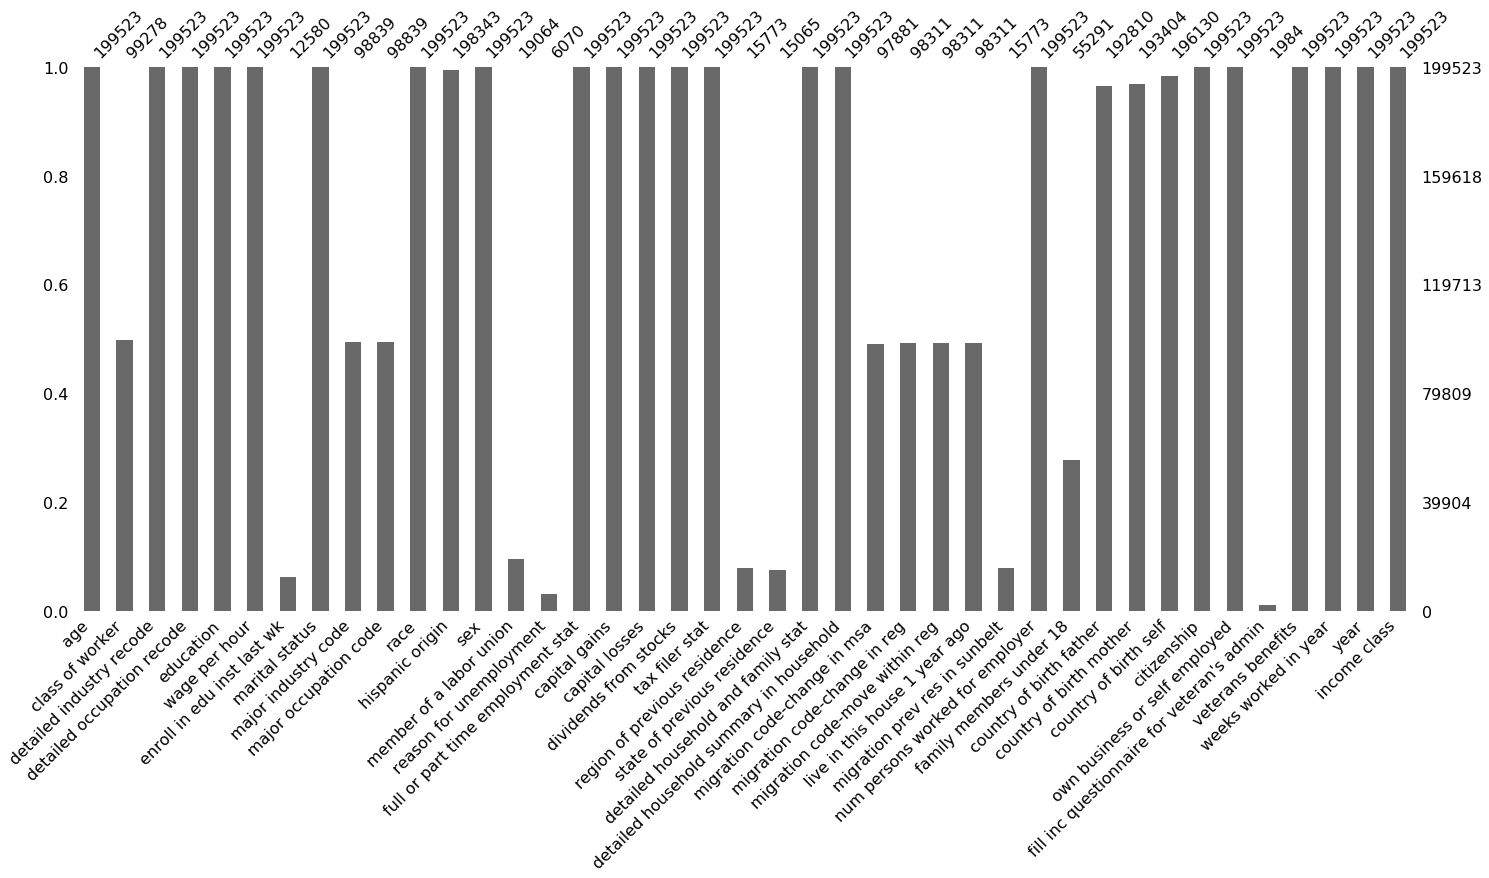

In [18]:
_ = msno.bar(census_clean)

In [19]:
column_nans = nans_count(census_clean)
column_nans.sort_values('nan_count', ascending=False)

,nan_count
fill inc questionnaire for veteran's admin,99.005628
reason for unemployment,96.957744
enroll in edu inst last wk,93.694962
state of previous residence,92.449492
migration prev res in sunbelt,92.094646
region of previous residence,92.094646
member of a labor union,90.445212
family members under 18,72.288408
migration code-change in msa,50.942498
migration code-change in reg,50.726984


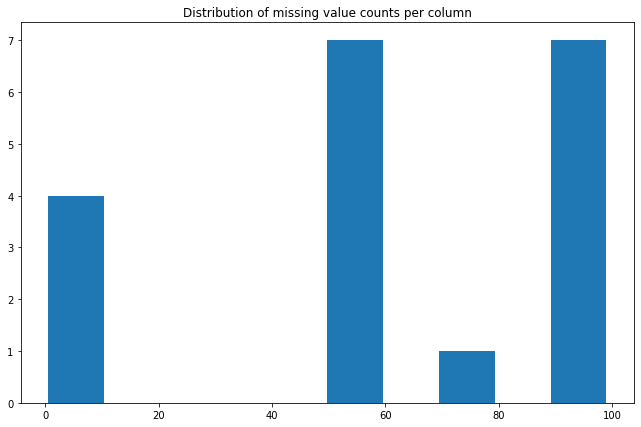

In [20]:
column_nans.hist(grid=False)
plt.title('Distribution of missing value counts per column')
plt.show()

In [21]:
column_nan_threshold = 50

nans_to_drop = column_nans[column_nans['nan_count'] > column_nan_threshold].index.tolist()
census_clean.drop(nans_to_drop, axis=1, inplace=True)

# droped columns
nans_to_drop

['class of worker',
 'enroll in edu inst last wk',
 'major industry code',
 'major occupation code',
 'member of a labor union',
 'reason for unemployment',
 'region of previous residence',
 'state of previous residence',
 'migration code-change in msa',
 'migration code-change in reg',
 'migration code-move within reg',
 'live in this house 1 year ago',
 'migration prev res in sunbelt',
 'family members under 18',
 "fill inc questionnaire for veteran's admin"]

In [22]:
column_nans = nans_count(census_clean)
column_nans.sort_values('nan_count', ascending=False)

,nan_count
country of birth father,3.364524
country of birth mother,3.066814
country of birth self,1.700556
hispanic origin,0.591411


In [23]:
categorical = census_clean.select_dtypes(include='object')
unique_values(categorical)

education: ['High school graduate', 'Some college but no degree', '10th grade', 'Children', 'Bachelors degree(BA AB BS)', 'Masters degree(MA MS MEng MEd MSW MBA)', 'Less than 1st grade', 'Associates degree-academic program', '7th and 8th grade', '12th grade no diploma', 'Associates degree-occup /vocational', 'Prof school degree (MD DDS DVM LLB JD)', '5th or 6th grade', '11th grade', 'Doctorate degree(PhD EdD)', '9th grade', '1st 2nd 3rd or 4th grade']
marital status: ['Widowed', 'Divorced', 'Never married', 'Married-civilian spouse present', 'Separated', 'Married-spouse absent', 'Married-A F spouse present']
race: ['White', 'Asian or Pacific Islander', 'Amer Indian Aleut or Eskimo', 'Black', 'Other']
hispanic origin: ['All other', nan, 'Central or South American', 'Mexican (Mexicano)', 'Mexican-American', 'Other Spanish', 'Puerto Rican', 'Cuban', 'Chicano']
sex: ['Female', 'Male']
full or part time employment stat: ['Not in labor force', 'Children or Armed Forces', 'Full-time schedules

Re-encode some columns

In [24]:
census_clean['sex'] = census_clean['sex'].map({'Female': 0, 'Male': 1})
census_clean['income class'] = census_clean['income class'].map({'- 50000.': 0, '50000+.': 1})

census_clean, _ = reduce_mem_usage(census_clean)
census_clean.info()

Memory usage of dataframe:  25.117076873779297  MB



___MEMORY USAGE AFTER COMPLETION:___
Memory usage is: 22.453157424926758 MB
This is 89.39% of the initial size
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 199523 entries, 0 to 199522
Data columns (total 26 columns):
 #   Column                                   Non-Null Count   Dtype 
---  ------                                   --------------   ----- 
 0   age                                      199523 non-null  uint8 
 1   detailed industry recode                 199523 non-null  uint8 
 2   detailed occupation recode               199523 non-null  uint8 
 3   education                                199523 non-null  object
 4   wage per hour                            199523 non-null  uint16
 5   marital status                           199523 non-null  object
 6   race                                     199523 non-null  object
 7   hispanic origin                          198343 non-null  object
 8   sex                                      199523 non-null  uint8 
 9   fu

In [25]:
census_clean = census_clean.fillna('Unknown')
census_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 199523 entries, 0 to 199522
Data columns (total 26 columns):
 #   Column                                   Non-Null Count   Dtype 
---  ------                                   --------------   ----- 
 0   age                                      199523 non-null  uint8 
 1   detailed industry recode                 199523 non-null  uint8 
 2   detailed occupation recode               199523 non-null  uint8 
 3   education                                199523 non-null  object
 4   wage per hour                            199523 non-null  uint16
 5   marital status                           199523 non-null  object
 6   race                                     199523 non-null  object
 7   hispanic origin                          199523 non-null  object
 8   sex                                      199523 non-null  uint8 
 9   full or part time employment stat        199523 non-null  object
 10  capital gains                            199

## One Hot Encode

In [26]:
categorical = census_clean.select_dtypes(include='object')
encoded = pd.get_dummies(categorical)

encoded.head()

,education_10th grade,education_11th grade,education_12th grade no diploma,education_1st 2nd 3rd or 4th grade,education_5th or 6th grade,education_7th and 8th grade,education_9th grade,education_Associates degree-academic program,education_Associates degree-occup /vocational,education_Bachelors degree(BA AB BS),...,country of birth self_Trinadad&Tobago,country of birth self_United-States,country of birth self_Unknown,country of birth self_Vietnam,country of birth self_Yugoslavia,citizenship_Foreign born- Not a citizen of U S,citizenship_Foreign born- U S citizen by naturalization,citizenship_Native- Born abroad of American Parent(s),citizenship_Native- Born in Puerto Rico or U S Outlying,citizenship_Native- Born in the United States
0,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,1
1,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,1
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,1,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,1
4,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,1


In [27]:
census_clean = census_clean.drop(categorical, axis=1)
census_clean = pd.concat([census_clean, encoded], axis=1)

census_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 199523 entries, 0 to 199522
Columns: 246 entries, age to citizenship_Native- Born in the United States
dtypes: uint16(2), uint32(2), uint8(242)
memory usage: 48.3 MB


## Scale

In [28]:
numerical = ['age', 'wage per hour', 'capital gains', 'capital losses', 'dividends from stocks']

scaler = StandardScaler()
census_clean[numerical] = scaler.fit_transform(census_clean[numerical])
census_clean.head()

,age,detailed industry recode,detailed occupation recode,wage per hour,sex,capital gains,capital losses,dividends from stocks,num persons worked for employer,own business or self employed,...,country of birth self_Trinadad&Tobago,country of birth self_United-States,country of birth self_Unknown,country of birth self_Vietnam,country of birth self_Yugoslavia,citizenship_Foreign born- Not a citizen of U S,citizenship_Foreign born- U S citizen by naturalization,citizenship_Native- Born abroad of American Parent(s),citizenship_Native- Born in Puerto Rico or U S Outlying,citizenship_Native- Born in the United States
0,1.725879,0,0,-0.201629,0,-0.092542,-0.137236,-0.099553,0,0,...,0,1,0,0,0,0,0,0,0,1
1,1.053560,4,34,-0.201629,1,-0.092542,-0.137236,-0.099553,1,0,...,0,1,0,0,0,0,0,0,0,1
2,-0.739291,0,0,-0.201629,0,-0.092542,-0.137236,-0.099553,0,0,...,0,0,0,1,0,1,0,0,0,0
3,-1.142682,0,0,-0.201629,0,-0.092542,-0.137236,-0.099553,0,0,...,0,1,0,0,0,0,0,0,0,1
4,-1.097861,0,0,-0.201629,0,-0.092542,-0.137236,-0.099553,0,0,...,0,1,0,0,0,0,0,0,0,1


## Dimensionality Reduction

In [29]:
# Print out the column correlations of the dataset
corr_matrix = census_clean.corr()
corr_matrix

,age,detailed industry recode,detailed occupation recode,wage per hour,sex,capital gains,capital losses,dividends from stocks,num persons worked for employer,own business or self employed,...,country of birth self_Trinadad&Tobago,country of birth self_United-States,country of birth self_Unknown,country of birth self_Vietnam,country of birth self_Yugoslavia,citizenship_Foreign born- Not a citizen of U S,citizenship_Foreign born- U S citizen by naturalization,citizenship_Native- Born abroad of American Parent(s),citizenship_Native- Born in Puerto Rico or U S Outlying,citizenship_Native- Born in the United States
age,1.000000,0.157822,0.117414,0.036938,-0.052560,0.053590,0.063351,0.104976,0.140887,-0.002265,...,0.004563,-0.064116,0.032290,-0.004354,0.012432,-0.001346,0.114889,-0.006549,0.021387,-0.064141
detailed industry recode,0.157822,1.000000,0.563493,0.165980,-0.025911,0.066017,0.072586,0.012774,0.642096,0.252694,...,0.003215,-0.025854,0.019526,-0.003612,-0.002048,0.003974,0.036342,0.014168,-0.003058,-0.025863
detailed occupation recode,0.117414,0.563493,1.000000,0.194498,0.138841,0.002534,0.043680,-0.026726,0.515554,0.228952,...,0.004534,-0.073951,0.004907,0.006822,-0.000252,0.073811,0.021680,0.006073,0.008000,-0.073924
wage per hour,0.036938,0.165980,0.194498,1.000000,0.023230,-0.001082,0.010993,-0.005731,0.191543,0.054051,...,0.002167,0.008415,0.002299,-0.002486,0.002593,-0.014599,0.009011,-0.001495,-0.004456,0.008406
sex,-0.052560,-0.025911,0.138841,0.023230,1.000000,0.054963,0.065799,0.011132,0.053625,0.036327,...,-0.001436,0.004283,0.003981,0.001537,0.004633,0.002048,-0.010319,0.006892,-0.008929,0.004301
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
citizenship_Foreign born- Not a citizen of U S,-0.001346,0.003974,0.073811,-0.014599,0.002048,-0.010700,-0.009319,-0.019078,-0.006627,-0.024629,...,0.041365,-0.752010,0.270107,0.102205,0.018242,1.000000,-0.046656,-0.025285,-0.023502,-0.752067
citizenship_Foreign born- U S citizen by naturalization,0.114889,0.036342,0.021680,0.009011,-0.010319,0.013232,0.006070,0.002143,0.030594,-0.015403,...,0.032765,-0.487291,0.217383,0.071532,0.067059,-0.046656,1.000000,-0.016384,-0.015229,-0.487328
citizenship_Native- Born abroad of American Parent(s),-0.006549,0.014168,0.006073,-0.001495,0.006892,0.000439,0.001879,0.000812,0.012954,0.009394,...,0.004188,-0.264082,0.143246,0.021305,0.004188,-0.025285,-0.016384,1.000000,-0.008253,-0.264102
citizenship_Native- Born in Puerto Rico or U S Outlying,0.021387,-0.003058,0.008000,-0.004456,-0.008929,-0.002783,-0.004225,-0.006517,-0.001595,-0.011090,...,-0.001593,-0.245469,-0.011520,-0.003881,-0.001593,-0.023502,-0.015229,-0.008253,1.000000,-0.245487


In [30]:
corrs = corr_matrix.abs().unstack().sort_values(kind='quicksort', ascending=False)
corrs[(corrs>0.80) & (corrs<1.0)]

country of birth self_United-States                                   citizenship_Native- Born in the United States                               0.999925
citizenship_Native- Born in the United States                         country of birth self_United-States                                         0.999925
detailed household and family stat_Spouse of householder              detailed household summary in household_Spouse of householder               0.999788
detailed household summary in household_Spouse of householder         detailed household and family stat_Spouse of householder                    0.999788
detailed household summary in household_Child under 18 never married  detailed household and family stat_Child <18 never marr not in subfamily    0.998673
                                                                                                                                                    ...   
country of birth self_Cuba                                            

In [31]:
# Set up PCA and the X vector for diminsionality reduction
pca = PCA(random_state=666)
census_X = census_clean.drop("income class", axis=1)

In [32]:
pca.fit(census_X)

PCA(copy=True, iterated_power='auto', n_components=None, random_state=666,
    svd_solver='auto', tol=0.0, whiten=False)

,Explained Cumulative Variance,Explained Variance Ratio,age,detailed industry recode,detailed occupation recode,wage per hour,sex,capital gains,capital losses,dividends from stocks,...,country of birth self_Trinadad&Tobago,country of birth self_United-States,country of birth self_Unknown,country of birth self_Vietnam,country of birth self_Yugoslavia,citizenship_Foreign born- Not a citizen of U S,citizenship_Foreign born- U S citizen by naturalization,citizenship_Native- Born abroad of American Parent(s),citizenship_Native- Born in Puerto Rico or U S Outlying,citizenship_Native- Born in the United States
Dimension 1,0.8084,0.8084,0.0065,0.5181,0.3565,0.0068,0.0014,0.0024,0.0030,0.0003,...,0.0000,-0.0005,0.0001,0.0000,-0.0000,0.0002,0.0002,0.0000,-0.0000,-0.0005
Dimension 2,0.9041,0.0957,-0.0007,-0.6955,0.7042,0.0052,0.0096,-0.0047,-0.0011,-0.0035,...,0.0000,-0.0016,-0.0002,0.0000,0.0000,0.0017,-0.0001,-0.0001,0.0001,-0.0016
Dimension 3,0.9879,0.0838,-0.0067,0.4970,0.6136,0.0029,-0.0034,-0.0067,-0.0050,-0.0035,...,-0.0000,-0.0011,0.0000,0.0000,-0.0000,0.0012,-0.0002,0.0000,0.0001,-0.0011
Dimension 4,0.9900,0.0021,0.0551,-0.0244,-0.0051,0.0641,-0.0102,-0.0033,0.0214,0.0075,...,-0.0000,0.0030,-0.0004,0.0001,-0.0000,-0.0042,0.0007,0.0002,0.0003,0.0030
Dimension 5,0.9917,0.0017,0.6438,-0.0025,-0.0020,-0.0160,-0.0348,0.0637,0.0554,0.1426,...,0.0001,-0.0256,0.0046,0.0002,0.0002,0.0101,0.0138,-0.0001,0.0019,-0.0257
Dimension 6,0.9927,0.0010,-0.0735,0.0001,0.0090,-0.0601,0.0594,0.6949,0.1203,0.6763,...,-0.0001,0.0150,-0.0011,-0.0003,-0.0001,-0.0100,-0.0037,-0.0001,-0.0012,0.0150
Dimension 7,0.9936,0.0009,-0.0102,0.0021,0.0013,-0.0755,0.0509,-0.2689,0.9435,0.0618,...,0.0001,0.0074,-0.0009,-0.0000,0.0000,-0.0049,-0.0021,0.0001,-0.0004,0.0074
Dimension 8,0.9944,0.0008,0.0054,0.0003,-0.0067,0.9886,0.0035,-0.0283,0.0617,0.1018,...,-0.0000,0.0182,-0.0014,-0.0003,0.0000,-0.0139,-0.0023,-0.0008,-0.0012,0.0182
Dimension 9,0.9952,0.0007,-0.0341,-0.0011,0.0001,-0.0782,-0.0537,-0.6423,-0.2119,0.7094,...,-0.0000,0.0103,-0.0026,-0.0001,-0.0001,-0.0051,-0.0040,-0.0002,-0.0011,0.0103
Dimension 10,0.9957,0.0005,-0.1563,-0.0032,0.0067,-0.0048,-0.1478,0.1097,0.1786,-0.0190,...,-0.0000,-0.0147,0.0001,0.0000,-0.0000,0.0131,0.0031,-0.0001,-0.0014,-0.0147


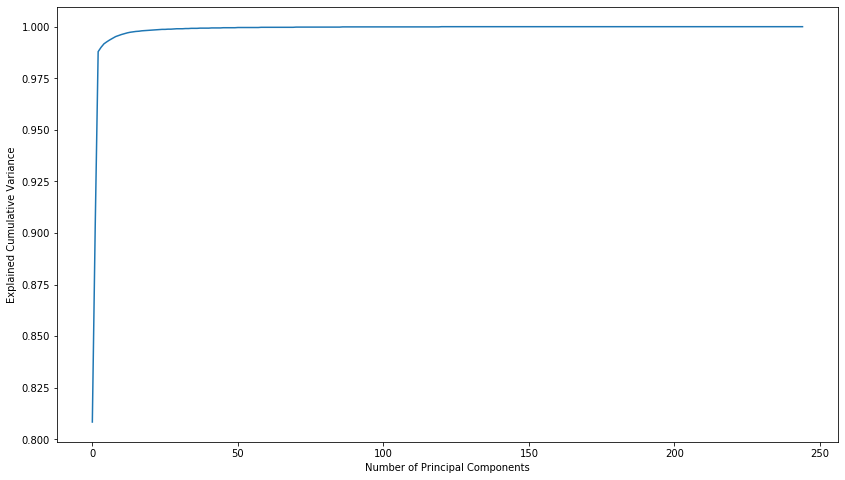

In [33]:
results = pca_results(census_X, pca)
results.head(10)

In [34]:
n_components = 10

In [35]:
explained_variance = results.iloc[n_components, 0]
explained_variance

0.9962

In [36]:
pca = PCA(n_components=n_components, random_state=666)
census_pca = pca.fit_transform(census_X)

In [37]:
print_pcs(census_X, pca, comp=1)

Weights for PC1
Top 5 weights
weeks worked in year               0.7746
detailed industry recode           0.5181
detailed occupation recode         0.3565
num persons worked for employer    0.0584
veterans benefits                  0.0155
Name: 0, dtype: float64


Bottom 5 weights
marital status_Never married                                               -0.0061
detailed household summary in household_Child under 18 never married       -0.0076
detailed household and family stat_Child <18 never marr not in subfamily   -0.0076
education_Children                                                         -0.0077
tax filer stat_Nonfiler                                                    -0.0113
Name: 0, dtype: float64


In [38]:
print_pcs(census_X, pca, comp=2)

Weights for PC2
Top 5 weights
detailed occupation recode        0.7042
weeks worked in year              0.1413
sex                               0.0096
education_High school graduate    0.0077
wage per hour                     0.0052
Name: 1, dtype: float64


Bottom 5 weights
detailed household and family stat_Spouse of householder   -0.0039
capital gains                                              -0.0047
num persons worked for employer                            -0.0054
education_Bachelors degree(BA AB BS)                       -0.0060
detailed industry recode                                   -0.6955
Name: 1, dtype: float64


In [39]:
print_pcs(census_X, pca, comp=3)

Weights for PC3
Top 5 weights
detailed occupation recode                                   0.6136
detailed industry recode                                     0.4970
marital status_Never married                                 0.0055
tax filer stat_Nonfiler                                      0.0043
detailed household summary in household_Child 18 or older    0.0034
Name: 2, dtype: float64


Bottom 5 weights
marital status_Married-civilian spouse present   -0.0059
age                                              -0.0067
capital gains                                    -0.0067
num persons worked for employer                  -0.0221
weeks worked in year                             -0.6129
Name: 2, dtype: float64


In [40]:
X = pd.DataFrame(census_pca, columns=[f'comp_{c+1}' for c in range(census_pca.shape[1])])
X.head()

,comp_1,comp_2,comp_3,comp_4,comp_5,comp_6,comp_7,comp_8,comp_9,comp_10
0,-30.047131,-0.549089,-0.323147,0.094969,2.231062,-0.462873,-0.139125,0.006473,-0.140666,-0.626465
1,24.507579,27.964472,-9.379467,-2.423512,0.749888,-0.076934,-0.010078,-0.303489,-0.036961,-0.881406
2,-30.070048,-0.546903,-0.289329,-0.060988,0.311240,-0.271709,-0.100106,-0.128212,-0.095432,-0.457406
3,-30.126841,-0.563604,-0.300821,-0.479269,-1.733652,0.174680,0.020914,0.052019,0.086779,0.237921
4,-30.126550,-0.563634,-0.301122,-0.476799,-1.704794,0.171387,0.020459,0.052262,0.085250,0.230916


In [41]:
y = census_clean['income class']
y.head()

0    0
1    0
2    0
3    0
4    0
Name: income class, dtype: uint8

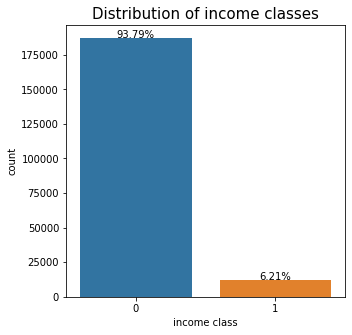

In [42]:
class_distribution(census_clean[['income class']])

## Feature Selection

In [43]:
selector = SelectKBest()
X_new = selector.fit_transform(census_X, y)

In [44]:
# Get columns to keep and create new dataframe with those only
cols = selector.get_support(indices=True)
features_df_new = census_X.iloc[:,cols]

In [45]:
features_df_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 199523 entries, 0 to 199522
Data columns (total 10 columns):
 #   Column                                               Non-Null Count   Dtype  
---  ------                                               --------------   -----  
 0   detailed industry recode                             199523 non-null  uint8  
 1   capital gains                                        199523 non-null  float64
 2   num persons worked for employer                      199523 non-null  uint8  
 3   weeks worked in year                                 199523 non-null  uint8  
 4   education_Masters degree(MA MS MEng MEd MSW MBA)     199523 non-null  uint8  
 5   education_Prof school degree (MD DDS DVM LLB JD)     199523 non-null  uint8  
 6   tax filer stat_Joint both under 65                   199523 non-null  uint8  
 7   tax filer stat_Nonfiler                              199523 non-null  uint8  
 8   detailed household and family stat_Householder       1

## Baseline Models

### PCA

In [46]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.3, stratify=y, random_state = 666)

In [47]:
clf_pca = SGDClassifier(random_state=666, loss='log', penalty='elasticnet', l1_ratio=0.7, class_weight={0:0.01, 1:1})

clf_pca.fit(X_train, y_train)
y_pred = clf_pca.predict(X_val)

print(f'ROC AUC score for training: {roc_auc_score(y_val, y_pred)}')

ROC AUC score for training: 0.7578790715889477


###  KBest

In [48]:
X_train, X_val, y_train, y_val = train_test_split(X_new, y, test_size = 0.3, stratify=y, random_state = 666)

In [49]:
clf_kbest = SGDClassifier(random_state=666, loss='log', penalty='elasticnet', l1_ratio=0.7, class_weight={0:0.01, 1:1})

clf_kbest.fit(X_train, y_train)
y_pred_new = clf_kbest.predict(X_val)

print(f'ROC AUC score for training: {roc_auc_score(y_val, y_pred)}')

ROC AUC score for training: 0.7578790715889477
